# Hyperparameters Database - New York State Salary Information for Public Sector

## Abstract

Hyperparameter is a parameter from a prior distribution which captures the prior belief before that data is observed. They directly control the behavior of training algorithm.
The goal of this skunkworks project is to find the best hyperparameters for the model and create a database by running millions of hyperparameter values, over thousands of datasets.

The objective is to create a database which has algorithms, tools and data that allows users to
choose hyperparameters that maximize the predictive power of their respective models. We will run the AutoML using H2O on the data set for different run times like 300, 500, 1000, 1500 and 2000 seconds and get the leaderboard for each run time to see the best models fetched by H2O. The analysis is on regression models and its corresponding hyperparameters.

## Dataset

The original dataset for NYS Salary Information for public sector prediction can be found on https://www.kaggle.com/new-york-state/nys-salary-information-for-the-public-sector#salary-information-for-local-authorities.csv. Public authorities are required by Section 2800 of Public Authorities Law to submit annual reports to the Authorities Budget Office that include salary and compensation data. The dataset consists of salary data by employee reported by Local Authorities beginning with fiscal years ending in 2011.                                        
Below is the description of the dataset used :                                                
1. Authority Name: Name of the Public Authority                                                         
2. Fiscal Year End Date: Date of Fiscal Year end for the authority                                            
3. Has Employees: N indicates that the authority reported having no staff. All the remaining fields are blank when authorities report having no staff.                                                           
4. Last Name: Last name of the employee                                                               
5. Middle Initial: Middle initial of the employee                                                                     
6. First Name: First name of the employee                                                                     
7. Title: Title of the employee
8. Group: : Indicates whether the employee’s position is either operational, administrative and clerical, technical and engineering, professional, managerial, or executive.                                                        
9. Department: Department (if any) that the employee works in. This field is blank if the authority didn’t enter any information.
10. Pay Type: Full time (FT) or part time (PT)                                                                  
11. Exempt Indicator: Y/N field to indicate whether the employee is exempt or non-exempt under the Fair Labor Standards Act (FLSA).
12. Base Annualized Salary: The annual base salary associated with a particular job title or position. For hourly or part-time staff, annualized salary would be the actual wages paid to the individual for the reporting period.                   
13. Actual Salary Paid: The actual salary or wages paid to the individual for the reporting period.                          
14. Overtime Paid: Extra cash payments to the individual for hours worked in excess of normal work week hours, as authorized by the authority’s policies, an employment contract or a collective bargaining agreement. Overtime would include holiday pay.     
15. Performance Bonus: A cash payment to the individual that does not become part of the base annualized salary.        
16. Extra Pay: Payments made to the individual for unused accrued vacation or personal time, commissions, longevity, as incentives for such purposes as excellent attendance or maintaining proper standing with professional licensure requirements; cash payments to the individual in lieu of an authority’s contribution to the individual’s pension fund or health insurance coverage; or other financial awards to the individual not based on performance goals.                                     
17. Other Compensation: Allowances, reimbursement for authorized expenses, or all other forms of taxable income not included in one of the above categories. This could include adjustments to previously paid compensation to correct payment errors.         
18. Total Compensation: Total payments made to the individual during the year including any overtime, bonus, extra, or other compensation amounts.                                                             
19. Paid By Another Entity: Y/N field that indicates whether the individual is paid by another entity to perform the work of the Authority.                                                                                              
20. Paid by State or Local Government: ‘Y’ indicates that the individual was paid by a State or local government to perform the work of the Authority, and is blank otherwise.                                                                                                                         

### Importing all the required libraries

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection  import train_test_split 
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error

In [2]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=2000
regression=True
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0

In [3]:
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,regression,scale,model,balance,
                  balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data_path
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['regression']=regression
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()   

In [4]:
run_id=alphabet(9)
if server_path==None:
  server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
  

# run_id to std out
print (run_id)

vifwqKWh5


In [5]:
logfile=run_id+'_autoh2o_log.zip'
logs_path=os.path.join(run_dir,'logs')
print(logs_path,' ',logfile)

C:\Users\sahan\Documents\Python_1\vifwqKWh5\logs   vifwqKWh5_autoh2o_log.zip


In [6]:
data_path = 'C:/Users/sahan/Documents/Python_1/salary-information-for-local-authorities.csv'

In [7]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,regression,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)
print(data_path)

{'start_time': 1556329647.4703612, 'target': None, 'server_path': 'C:\\Users\\sahan\\Documents\\Python_1', 'data_path': 'C:/Users/sahan/Documents/Python_1/salary-information-for-local-authorities.csv', 'test_path': None, 'max_models': 9, 'run_time': 2000, 'run_id': 'vifwqKWh5', 'scale': False, 'regression': True, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1556329647.4703612, 'execution_time': 0.0, 'run_path': 'C:\\Users\\sahan\\Documents\\Python_1\\vifwqKWh5', 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}
C:/Users/sahan/Documents/Python_1/salary-information-for-local-authorities.csv


In [8]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

3


In [9]:
# Connect to a cluster
#port_no=random.randint(5555,55555)
port_no = 54321
h2o.init(strict_version_check=False) # start h2o

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Picked up _JAVA_OPTIONS: -Xmx256M (build 25.201-b09, mixed mode)
  Starting server from C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\sahan\AppData\Local\Temp\tmpcbhjkww6
  JVM stdout: C:\Users\sahan\AppData\Local\Temp\tmpcbhjkww6\h2o_sahan_started_from_python.out
  JVM stderr: C:\Users\sahan\AppData\Local\Temp\tmpcbhjkww6\h2o_sahan_started_from_python.err
  Server is running at http://127.0.0.1:54329
Connecting to H2O server at http://127.0.0.1:54329 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_sahan_1sl0le
H2O cluster total nodes:,1
H2O cluster free memory:,243.5 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [10]:
#importing data using pandas data library
df=pd.read_csv("salary-information-for-local-authorities.csv", decimal = '.')

In [11]:
df.head()

,Authority Name,Fiscal Year End Date,Has Employees,Last Name,Middle Initial,First Name,Title,Group,Department,Pay Type,Exempt Indicator,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation,Paid By Another Entity,Paid by State or Local Government
0,Water Authority of Great Neck North,2014-12-31T00:00:00.000,NaN,Paulino,NaN,Elvin,Water Servicer,Operational,Maintenance,FT,N,81598.0,81598.00,2264.00,300.0,275.0,236.00,84673.00,N,NaN
1,Water Authority of Great Neck North,2014-12-31T00:00:00.000,NaN,Avila,NaN,Oscar,Water Plant Operator,Operational,Operations,FT,N,83019.0,83019.00,4219.00,400.0,1925.0,3054.00,92617.00,N,NaN
2,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,NaN,OGBONNA,NaN,CHIDINMA,STAFF NURSE,Professional,NaN,FT,N,85661.0,83635.52,251.62,NaN,NaN,10358.59,94245.73,N,NaN
3,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,NaN,GAZARIAN,NaN,TANIA,ASO NURSE PRACTITIONR-LII,Professional,NaN,FT,N,114322.0,111648.24,NaN,NaN,NaN,5465.33,117113.57,N,NaN
4,New York City Health and Hospitals Corporation,2011-06-30T00:00:00.000,NaN,SINCLAIR,NaN,SAUDIA,SOCIAL WORKER - LVL I,Technical and Engineering,NaN,FT,N,53503.0,53356.42,NaN,NaN,NaN,-102.48,53253.94,N,NaN


In [12]:
df.describe()

,Has Employees,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation
count,0.0,344306.000000,335413.000000,201718.000000,372.000000,17149.000000,303765.000000,344250.000000
mean,NaN,60306.367801,54515.826442,5677.951724,2455.076640,5988.023773,1895.209327,58416.738212
std,NaN,32634.715153,33184.844889,9330.912500,2214.953782,16423.631591,6464.990317,36989.218760
min,NaN,1.000000,0.780000,0.300000,29.890000,0.100000,-122199.330000,0.010000
25%,NaN,37976.080000,35038.640000,527.360000,1231.940000,750.000000,114.000000,37058.975000
50%,NaN,52517.500000,44244.010000,1722.345000,1951.885000,1300.890000,659.410000,49891.965000
75%,NaN,75096.000000,71791.720000,6687.480000,2987.870000,3897.200000,3020.360000,77424.640000
max,NaN,617655.210000,516448.210000,280145.000000,13225.120000,450975.100000,525536.000000,571175.360000


In [13]:
#checking the columns of theh dataset
df.columns

Index(['Authority Name', 'Fiscal Year End Date', 'Has Employees', 'Last Name',
       'Middle Initial', 'First Name', 'Title', 'Group', 'Department',
       'Pay Type', 'Exempt Indicator', 'Base Annualized Salary',
       'Actual Salary Paid', 'Overtime Paid', 'Performance Bonus', 'Extra Pay',
       'Other Compensation', 'Total Compensation', 'Paid By Another Entity',
       'Paid by State or Local Government'],
      dtype='object')

In [14]:
#checking for the null values
df.isna().any()

Authority Name                       False
Fiscal Year End Date                 False
Has Employees                         True
Last Name                             True
Middle Initial                        True
First Name                            True
Title                                False
Group                                False
Department                            True
Pay Type                             False
Exempt Indicator                     False
Base Annualized Salary               False
Actual Salary Paid                    True
Overtime Paid                         True
Performance Bonus                     True
Extra Pay                             True
Other Compensation                    True
Total Compensation                    True
Paid By Another Entity               False
Paid by State or Local Government     True
dtype: bool

In [15]:


#to check for the total null values in every columns of the dataset
df.isna().sum()

Authority Name                            0
Fiscal Year End Date                      0
Has Employees                        344306
Last Name                                 4
Middle Initial                       333777
First Name                                5
Title                                     0
Group                                     0
Department                           334631
Pay Type                                  0
Exempt Indicator                          0
Base Annualized Salary                    0
Actual Salary Paid                     8893
Overtime Paid                        142588
Performance Bonus                    343934
Extra Pay                            327157
Other Compensation                    40541
Total Compensation                       56
Paid By Another Entity                    0
Paid by State or Local Government    343454
dtype: int64

In [16]:
#to check for the total number of columns and entries in the dataset
df.shape

(344306, 20)

In [17]:
#to drop the columns with large null values
df.drop(columns=['Has Employees', 'Middle Initial', 'Paid by State or Local Government','Department'], axis=1, inplace=True)
df.head()

,Authority Name,Fiscal Year End Date,Last Name,First Name,Title,Group,Pay Type,Exempt Indicator,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation,Paid By Another Entity
0,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Paulino,Elvin,Water Servicer,Operational,FT,N,81598.0,81598.00,2264.00,300.0,275.0,236.00,84673.00,N
1,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Avila,Oscar,Water Plant Operator,Operational,FT,N,83019.0,83019.00,4219.00,400.0,1925.0,3054.00,92617.00,N
2,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,OGBONNA,CHIDINMA,STAFF NURSE,Professional,FT,N,85661.0,83635.52,251.62,NaN,NaN,10358.59,94245.73,N
3,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,GAZARIAN,TANIA,ASO NURSE PRACTITIONR-LII,Professional,FT,N,114322.0,111648.24,NaN,NaN,NaN,5465.33,117113.57,N
4,New York City Health and Hospitals Corporation,2011-06-30T00:00:00.000,SINCLAIR,SAUDIA,SOCIAL WORKER - LVL I,Technical and Engineering,FT,N,53503.0,53356.42,NaN,NaN,NaN,-102.48,53253.94,N


In [18]:
p=df.loc[:,"Total Compensation"].mean()
df["Total Compensation"].fillna(p, inplace=True)
q=0
df["Overtime Paid"].fillna(q,inplace=True)
df["Performance Bonus"].fillna(q,inplace=True)
df["Extra Pay"].fillna(q,inplace=True)
r=df.loc[:,"Other Compensation"].mean()
df["Other Compensation"].fillna(r, inplace=True)
s=df.loc[:,"Actual Salary Paid"].mean()
df["Actual Salary Paid"].fillna(s, inplace=True)
ln="X"
df["Last Name"].fillna(ln,inplace=True)
fn="XX"
df["First Name"].fillna(fn,inplace=True)

In [19]:
#to cross check the total number of null values in every column on dropping the columns with large null values and 
#is of no use to us
df.isna().sum()

Authority Name            0
Fiscal Year End Date      0
Last Name                 0
First Name                0
Title                     0
Group                     0
Pay Type                  0
Exempt Indicator          0
Base Annualized Salary    0
Actual Salary Paid        0
Overtime Paid             0
Performance Bonus         0
Extra Pay                 0
Other Compensation        0
Total Compensation        0
Paid By Another Entity    0
dtype: int64

In [20]:
#to check the count of the categorical values
df['Group'].value_counts()

Professional                   102349
Operational                     89381
Technical and Engineering       70121
Administrative and Clerical     52154
Managerial                      28960
Executive                        1341
Name: Group, dtype: int64

In [21]:
df=pd.get_dummies(df,columns=['Group'],drop_first= True)
df=pd.get_dummies(df,columns=['Pay Type'],drop_first=True)
df.columns

Index(['Authority Name', 'Fiscal Year End Date', 'Last Name', 'First Name',
       'Title', 'Exempt Indicator', 'Base Annualized Salary',
       'Actual Salary Paid', 'Overtime Paid', 'Performance Bonus', 'Extra Pay',
       'Other Compensation', 'Total Compensation', 'Paid By Another Entity',
       'Group_Executive', 'Group_Managerial', 'Group_Operational',
       'Group_Professional', 'Group_Technical and Engineering', 'Pay Type_PT'],
      dtype='object')

In [22]:
#using pandas to find the correlation of all the columns in the dataset
df.corr()

,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation,Group_Executive,Group_Managerial,Group_Operational,Group_Professional,Group_Technical and Engineering,Pay Type_PT
Base Annualized Salary,1.000000,0.887340,-0.004298,-0.013038,0.129485,0.151864,0.822136,0.126689,0.378478,-0.352444,0.348017,-0.082881,-0.261253
Actual Salary Paid,0.887340,1.000000,0.054236,-0.008989,0.012833,0.166487,0.924517,0.113787,0.329887,-0.290774,0.271076,-0.068811,-0.221562
Overtime Paid,-0.004298,0.054236,1.000000,0.013349,-0.018196,0.189928,0.302071,-0.027054,-0.120931,0.221327,-0.023338,-0.054703,-0.056163
Performance Bonus,-0.013038,-0.008989,0.013349,1.000000,-0.001583,-0.001780,-0.002350,0.002337,-0.007113,0.037555,-0.015770,-0.012251,-0.007028
Extra Pay,0.129485,0.012833,-0.018196,-0.001583,1.000000,-0.005291,0.096496,0.066558,0.112742,-0.012716,-0.032933,-0.020872,-0.011476
Other Compensation,0.151864,0.166487,0.189928,-0.001780,-0.005291,1.000000,0.335765,0.022926,-0.002096,0.049854,0.051422,-0.054267,-0.025013
Total Compensation,0.822136,0.924517,0.302071,-0.002350,0.096496,0.335765,1.000000,0.106125,0.279375,-0.206193,0.247386,-0.088112,-0.207927
Group_Executive,0.126689,0.113787,-0.027054,0.002337,0.066558,0.022926,0.106125,1.000000,-0.018949,-0.037026,-0.040669,-0.031622,0.018022
Group_Managerial,0.378478,0.329887,-0.120931,-0.007113,0.112742,-0.002096,0.279375,-0.018949,1.000000,-0.179441,-0.197096,-0.153253,-0.045311
Group_Operational,-0.352444,-0.290774,0.221327,0.037555,-0.012716,0.049854,-0.206193,-0.037026,-0.179441,1.000000,-0.385114,-0.299446,0.096471


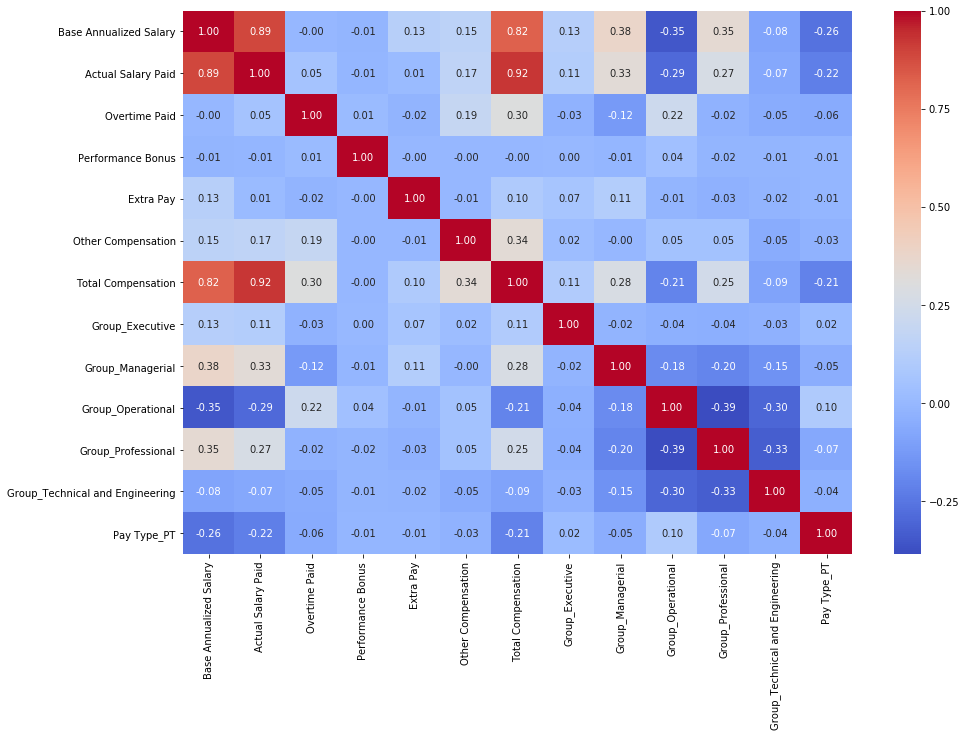

In [23]:
#using matplotlib library plotting the heatmap
plt.figure(figsize=(15,10))
sns.heatmap(data=df.iloc[:,2:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

In [24]:
df.to_csv('train.csv')

In [25]:
data_dir = os.getcwd()
data_path = data_dir + '/train.csv'

In [26]:
#Ingest data
train_data = h2o.import_file(path = data_path, destination_frame = "train_data")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
df.dtypes

Authority Name                      object
Fiscal Year End Date                object
Last Name                           object
First Name                          object
Title                               object
Exempt Indicator                    object
Base Annualized Salary             float64
Actual Salary Paid                 float64
Overtime Paid                      float64
Performance Bonus                  float64
Extra Pay                          float64
Other Compensation                 float64
Total Compensation                 float64
Paid By Another Entity              object
Group_Executive                      uint8
Group_Managerial                     uint8
Group_Operational                    uint8
Group_Professional                   uint8
Group_Technical and Engineering      uint8
Pay Type_PT                          uint8
dtype: object

In [28]:
z=df.columns
metadata=pd.DataFrame(columns=['Columns'])
for column in z:
    variable=""
    if column!= "Total Compensation":
        variable = "Independent"
    else:
        variable = "Dependent"
    metadata = metadata.append(pd.DataFrame({'Columns':column, 'Variable type':variable , 'Data Type': df[column].dtypes},index=[0]))
metadata.head(20)

,Columns,Data Type,Variable type
0,Authority Name,object,Independent
0,Fiscal Year End Date,object,Independent
0,Last Name,object,Independent
0,First Name,object,Independent
0,Title,object,Independent
0,Exempt Indicator,object,Independent
0,Base Annualized Salary,float64,Independent
0,Actual Salary Paid,float64,Independent
0,Overtime Paid,float64,Independent
0,Performance Bonus,float64,Independent


In [29]:
metadata.to_csv("metadata.csv", index=False)

In [30]:
train_data.show()

C1,Authority Name,Fiscal Year End Date,Last Name,First Name,Title,Exempt Indicator,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation,Paid By Another Entity,Group_Executive,Group_Managerial,Group_Operational,Group_Professional,Group_Technical and Engineering,Pay Type_PT
0,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Paulino,Elvin,Water Servicer,N,81598,81598,2264,300,275,236,84673,N,0,0,1,0,0,0
1,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Avila,Oscar,Water Plant Operator,N,83019,83019,4219,400,1925,3054,92617,N,0,0,1,0,0,0
2,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,OGBONNA,CHIDINMA,STAFF NURSE,N,85661,83635.5,251.62,0,0,10358.6,94245.7,N,0,0,0,1,0,0
3,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,GAZARIAN,TANIA,ASO NURSE PRACTITIONR-LII,N,114322,111648,0,0,0,5465.33,117114,N,0,0,0,1,0,0
4,New York City Health and Hospitals Corporation,2011-06-30T00:00:00.000,SINCLAIR,SAUDIA,SOCIAL WORKER - LVL I,N,53503,53356.4,0,0,0,-102.48,53253.9,N,0,0,0,0,1,0
5,Suffolk County Water Authority,2015-05-31T00:00:00.000,POSILLICO,FRANK,General Utility A,N,71053,71893.7,0,0,0,1895.21,71893.7,N,0,0,1,0,0,0
6,New York City Health and Hospitals Corporation,2016-06-30T00:00:00.000,CHOI,MOONSOOK,STAFF NURSE,N,72960,73999.9,13668.5,0,0,5181.5,92849.8,N,0,0,0,1,0,0
7,New York City Health and Hospitals Corporation,2013-06-30T00:00:00.000,PALUMBO,PATRICIA,LICENSED PRACTICAL NURSE,N,40897,40761,8590.41,0,0,550.11,49901.5,N,0,0,0,1,0,0
8,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Martinez,Juan,Water Servicer,N,81556,81556,5783,300,0,1895.21,87639,N,0,0,1,0,0,0
9,New York City Health and Hospitals Corporation,2011-06-30T00:00:00.000,RAMSAY,PAULA,HEAD NURSE,N,82383,82128.2,10525.8,0,0,544.58,93198.6,N,0,0,0,1,0,0


In [31]:
# used to gain statistical information of the columns present in the dataset
train_data.describe()

Rows:344306
Cols:21




,C1,Authority Name,Fiscal Year End Date,Last Name,First Name,Title,Exempt Indicator,Base Annualized Salary,Actual Salary Paid,Overtime Paid,Performance Bonus,Extra Pay,Other Compensation,Total Compensation,Paid By Another Entity,Group_Executive,Group_Managerial,Group_Operational,Group_Professional,Group_Technical and Engineering,Pay Type_PT
type,int,enum,enum,enum,enum,enum,enum,real,real,real,real,real,real,real,enum,int,int,int,int,int,int
mins,0.0,,,,,,,1.0,0.78,0.0,0.0,0.0,-122199.33,0.01,,0.0,0.0,0.0,0.0,0.0,0.0
mean,172152.5,,,,,,,60306.367801113,54515.82644181933,3326.532403937196,2.6525489245032037,298.2481271891863,1895.209326551799,58416.73821196804,,0.0038947912612617847,0.0841112266414178,0.2595975672802681,0.29726173810505774,0.20365895453462907,0.08044588244178144
maxs,344305.0,,,,,,,617655.21,516448.21,280145.0,13225.12,450975.1,525536.0,571175.36,,1.0,1.0,1.0,1.0,1.0,1.0
sigma,99392.72522926414,,,,,,,32634.715152986144,32753.47815616403,7670.147664054116,108.58909940454942,3889.8674201740682,6072.455843161744,36986.21055428434,,0.0622867010707182,0.27755495300806865,0.438414448425003,0.4570533928166115,0.4027188297238042,0.271982641525419
zeros,1,,,,,,,0,0,142588,343934,327157,0,0,,342965,315346,254925,241957,274185,316608
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Paulino,Elvin,Water Servicer,N,81598.0,81598.0,2264.0,300.0,275.0,236.0,84673.0,N,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,Water Authority of Great Neck North,2014-12-31T00:00:00.000,Avila,Oscar,Water Plant Operator,N,83019.0,83019.0,4219.0,400.0,1925.0,3054.0,92617.0,N,0.0,0.0,1.0,0.0,0.0,0.0
2,2.0,New York City Health and Hospitals Corporation,2017-06-30T00:00:00.000,OGBONNA,CHIDINMA,STAFF NURSE,N,85661.0,83635.52,251.62,0.0,0.0,10358.59,94245.73,N,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
target = 'Total Compensation'

def get_independent_variables(train_data, targ):
    C = [name for name in train_data.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in train_data.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x = ints + enums + reals
    return x

X = get_independent_variables(train_data, target) 
print(X)
y = target

['C1', 'Group_Executive', 'Group_Managerial', 'Group_Operational', 'Group_Professional', 'Group_Technical and Engineering', 'Pay Type_PT', 'Authority Name', 'Fiscal Year End Date', 'Last Name', 'First Name', 'Title', 'Exempt Indicator', 'Paid By Another Entity', 'Base Annualized Salary', 'Actual Salary Paid', 'Overtime Paid', 'Performance Bonus', 'Extra Pay', 'Other Compensation']


In [33]:
# setup autoML
# min_mem_size=6 
run_time=2000
aml = H2OAutoML(max_runtime_secs=run_time)

In [ ]:
model_start_time = time.time()
try:
 aml.train(x=X,y=y,training_frame=train_data)  # Change training_frame=train
except Exception as e:
 logging.critical('aml.train')
 h2o.download_all_logs(dirname=logs_path, filename=logfile)
 h2o.cluster().shutdown()
 sys.exit(4)

AutoML progress: |████

CRITICAL:root:aml.train


In [71]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [72]:
n=run_id+'_'+str(run_time)+'_MetaData.json'
dict_to_json(meta_data,n)

In [73]:
# view leaderboard
lb = aml.leaderboard
lb.head(100)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_1_AutoML_20190420_141222,1.99793e+06,1413.48,1.99793e+06,392.198,nan
GBM_2_AutoML_20190420_141222,2.49694e+06,1580.17,2.49694e+06,584.237,nan
StackedEnsemble_AllModels_AutoML_20190420_141222,1.21511e+09,34858.5,1.21511e+09,25434.8,1.12222
StackedEnsemble_BestOfFamily_AutoML_20190420_141222,1.26607e+09,35581.8,1.26607e+09,25963.6,1.13041
GLM_grid_1_AutoML_20190420_141222_model_1,1.36797e+09,36986.1,1.36797e+09,27018.3,1.14518


In [74]:
model1 = h2o.get_model(lb[0,'model_id'])

In [75]:
model2 = h2o.get_model(lb[1,'model_id'])
model3 = h2o.get_model(lb[2,'model_id'])
model4 = h2o.get_model(lb[3,'model_id'])
model5 = h2o.get_model(lb[4,'model_id'])

In [76]:
model1.model_id

'GBM_1_AutoML_20190420_141222'

In [77]:
leaderboard=lb.as_data_frame()
n=run_id+'_'+str(run_time)+'_Leaderboard.json'
leaderboard.to_json(n)

In [79]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()
model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[4])

In [80]:
hy_parameter = model1.params
n=model1.model_id+'_hyparameter.json'
dict_to_json(hy_parameter,n) # this is a function

hy_parameter = model2.params
n=model2.model_id+'_hyparameter.json'
dict_to_json(hy_parameter,n) # this is a function

hy_parameter = model3.params
n=model3.model_id+'_hyparameter.json'
dict_to_json(hy_parameter,n) # this is a function

hy_parameter = model4.params
n=model4.model_id+'_hyparameter.json'
dict_to_json(hy_parameter,n) # this is a function

hy_parameter = model5.params
n=model5.model_id+'_hyparameter.json'
dict_to_json(hy_parameter,n) # this is a function